In [44]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt


In [45]:
# Transformations: convert to tensor + normalize to [-1, 1]
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Download CIFAR-10 dataset
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=1000, shuffle=False, num_workers=2)

classes = ['airplane', 'automobile', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck']

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cpu


In [46]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class CIFAR10Model(nn.Module):
    def __init__(self):
        super(CIFAR10Model, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)

        # compute the flatten size dynamically
        self._to_linear = None
        self._get_flatten_size()

        self.fc1 = nn.Linear(self._to_linear, 128)
        self.fc2 = nn.Linear(128, 10)

    def _get_flatten_size(self):
        x = torch.randn(1, 3, 32, 32)
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        self._to_linear = x.numel()

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, self._to_linear)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x


In [47]:
model = CIFAR10Model().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [49]:
epochs = 10 

for epoch in range(epochs):
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if i % 100 == 99:
            print(f"[Epoch {epoch+1}, Batch {i+1}] loss: {running_loss/100:.3f}")
            running_loss = 0.0

print("Finished Training")


[Epoch 1, Batch 100] loss: 0.591
[Epoch 1, Batch 200] loss: 0.571
[Epoch 1, Batch 300] loss: 0.577
[Epoch 1, Batch 400] loss: 0.616
[Epoch 1, Batch 500] loss: 0.591
[Epoch 1, Batch 600] loss: 0.612
[Epoch 1, Batch 700] loss: 0.605
[Epoch 2, Batch 100] loss: 0.473
[Epoch 2, Batch 200] loss: 0.498
[Epoch 2, Batch 300] loss: 0.509
[Epoch 2, Batch 400] loss: 0.468
[Epoch 2, Batch 500] loss: 0.514
[Epoch 2, Batch 600] loss: 0.529
[Epoch 2, Batch 700] loss: 0.522
[Epoch 3, Batch 100] loss: 0.378
[Epoch 3, Batch 200] loss: 0.385
[Epoch 3, Batch 300] loss: 0.407
[Epoch 3, Batch 400] loss: 0.413
[Epoch 3, Batch 500] loss: 0.429
[Epoch 3, Batch 600] loss: 0.438
[Epoch 3, Batch 700] loss: 0.439
[Epoch 4, Batch 100] loss: 0.304
[Epoch 4, Batch 200] loss: 0.302
[Epoch 4, Batch 300] loss: 0.342
[Epoch 4, Batch 400] loss: 0.349
[Epoch 4, Batch 500] loss: 0.349
[Epoch 4, Batch 600] loss: 0.352
[Epoch 4, Batch 700] loss: 0.352
[Epoch 5, Batch 100] loss: 0.235
[Epoch 5, Batch 200] loss: 0.236
[Epoch 5, 

In [ ]:
correct = 0
total = 0
model.eval()
with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Test Accuracy: {100 * correct / total:.2f}%")


Test Accuracy: 74.75%


In [52]:
torch.save(model.state_dict(), "../models/cifar10_model.pth")
print("Model saved successfully to models/cifar10_model.pth")


Model saved successfully to models/cifar10_model.pth


              precision    recall  f1-score   support

    airplane       0.77      0.70      0.73      1000
  automobile       0.78      0.81      0.79      1000
        bird       0.53      0.68      0.60      1000
         cat       0.57      0.46      0.51      1000
        deer       0.63      0.68      0.65      1000
         dog       0.62      0.62      0.62      1000
        frog       0.82      0.73      0.77      1000
       horse       0.75      0.77      0.76      1000
        ship       0.85      0.80      0.82      1000
       truck       0.78      0.79      0.78      1000

    accuracy                           0.70     10000
   macro avg       0.71      0.70      0.70     10000
weighted avg       0.71      0.70      0.70     10000



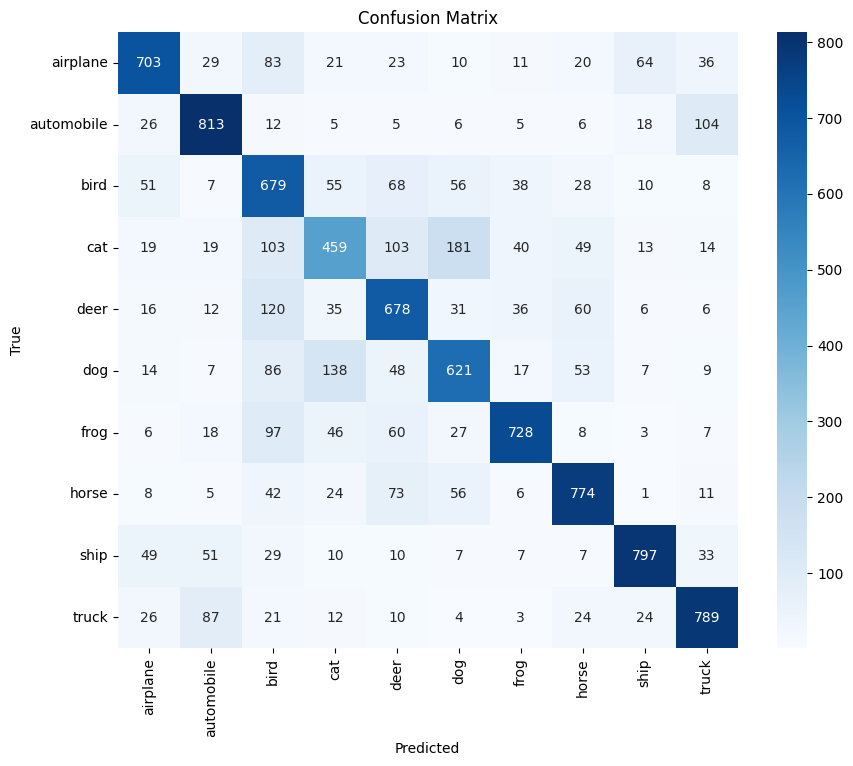

In [51]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# Evaluate model
model.eval()
y_true, y_pred = [], []

with torch.no_grad():
    for images, labels in testloader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

print(classification_report(y_true, y_pred, target_names=classes))

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()
